## Get data

In [1]:
import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta, datetime, timezone
from vnstock3 import Vnstock
import requests

In [2]:
stock_list = []
volume_list = []

for i in glob.glob(r'D:\Quantitative_Research\H-Tech\vnstock_data\*.csv'):
    stocks = pd.read_csv(i).set_index('time')['close'].reset_index()
    volume = pd.read_csv(i).set_index('time')['volume'].reset_index()
    stocks.columns = ['time', i[-7:-3]]
    volume.columns = ['time', i[-7:-3]]
    stock_list.append(stocks.set_index('time'))
    volume_list.append(volume.set_index('time'))

stock_universe_price = pd.concat(stock_list, axis = 1).sort_index()
stock_universe_vol = pd.concat(volume_list, axis = 1).sort_index()

## Data handling

In [3]:
stock_universe_price.rename(columns=lambda x: x[:-1] if x != 'time' else x, inplace=True)
stock_universe_price.index = pd.to_datetime(stock_universe_price.index)
stock_universe_vol.rename(columns=lambda x: x[:-1] if x != 'time' else x, inplace=True)
stock_universe_vol.index = pd.to_datetime(stock_universe_vol.index)

## Get industry

In [4]:
stock = Vnstock().stock()
industries = stock.listing.symbols_by_industries()
industry_counts = industries['en_icb_name3'].value_counts()
valid_industries = industry_counts[industry_counts >= 3].index.tolist()

print(f"Valid industries: {valid_industries}")

valid_industries = list(set(valid_industries))

2024-08-06 18:25:59,259 - vnstock3.common.vnstock - INFO - Mã chứng khoán không được chỉ định, chương trình mặc định sử dụng VN30F1M
2024-08-06 18:25:59,279 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


Valid industries: ['Construction & Materials', 'Real Estate Investment & Services', 'Industrial Transportation', 'Food Producers', 'Gas, Water & Multi-utilities', 'Chemicals', 'Personal Goods', 'Support Services', 'Electricity', 'Travel & Leisure', 'Pharmaceuticals & Biotechnology', 'Industrial Metals & Mining', 'Mining', 'Beverages', 'Financial Services', 'Industrial Engineering', 'Media', 'General Industrials', 'Banks', 'General Retailers', 'Electronic & Electrical Equipment', 'Forestry & Paper', 'Automobiles & Parts', 'Technology Hardware & Equipment', 'Software & Computer Services', 'Nonlife Insurance', 'Health Care Equipment & Services', 'Household Goods & Home Construction', 'Oil Equipment, Services & Distribution', 'Fixed Line Telecommunications', 'Food & Drug Retailers', 'Tobacco', 'Oil & Gas Producers', 'Mobile Telecommunications', 'Leisure Goods']


## Specify universe by Industry

In [5]:
ticker_list = industries[industries['en_icb_name3'] == 'Personal Goods']['symbol'].tolist()
available_tickers = [ticker for ticker in ticker_list if ticker in stock_universe_price.columns]
stock_universe = stock_universe_price[available_tickers]
stock_universe = stock_universe.ffill().fillna(0)
stock_universe.index = pd.to_datetime(stock_universe.index)
stock_universe.index = stock_universe.index.date
stock_universe.index.name = 'date'
stock_universe

,SGI,BVN,BDG,PNJ,ADS,A32,THM,AG1,M10,STK,...,VTI,G20,TVT,HDM,TDT,ASA,BKG,NDT,CET,VGT
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.0,4.93,0.0,6.81,0.00,0.0,0.0,0.0,0.0,0.00,...,2.5,0.0,0.00,3.67,0.0,13.91,0.00,0.0,0.0,0.0
2013-01-03,0.0,5.35,0.0,6.98,0.00,0.0,0.0,0.0,0.0,0.00,...,2.7,0.0,0.00,3.67,0.0,13.53,0.00,0.0,0.0,0.0
2013-01-04,0.0,5.85,0.0,6.81,0.00,0.0,0.0,0.0,0.0,0.00,...,2.7,0.0,0.00,3.67,0.0,13.82,0.00,0.0,0.0,0.0
2013-01-07,0.0,5.44,0.0,6.81,0.00,0.0,0.0,0.0,0.0,0.00,...,2.7,0.0,0.00,3.67,0.0,13.62,0.00,0.0,0.0,0.0
2013-01-08,0.0,5.44,0.0,6.61,0.00,0.0,0.0,0.0,0.0,0.00,...,2.7,0.0,0.00,3.67,0.0,14.01,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-18,15.0,14.10,35.3,96.00,12.25,38.9,9.0,9.0,25.7,34.40,...,4.0,0.6,16.40,32.00,7.1,12.60,4.01,6.7,6.4,16.7
2024-07-19,15.0,14.10,35.4,95.70,12.00,38.9,9.0,9.1,24.8,34.65,...,4.0,0.6,16.55,32.30,7.1,12.60,3.97,6.4,6.3,16.4
2024-07-22,15.8,12.40,35.4,94.20,11.40,35.0,9.0,9.3,24.2,32.25,...,4.0,0.6,16.55,31.80,7.1,12.60,3.95,6.4,6.2,15.3


In [6]:
ticker_list = industries[industries['en_icb_name3'] == 'Personal Goods']['symbol'].tolist()
available_tickers = [ticker for ticker in ticker_list if ticker in stock_universe_vol.columns]
vol = stock_universe_vol[available_tickers]
vol = vol.fillna(0)
vol.index = pd.to_datetime(vol.index)
vol.index = vol.index.date
vol.index.name = 'date'

## Most liquid tickers

In [7]:
average_volume = vol.mean()
sorted_tickers = average_volume.sort_values(ascending=False)
top_3_tickers = sorted_tickers.head(3).index.tolist()
stock_universe = stock_universe[top_3_tickers]
stock_universe

,TNG,VGT,TCM
date,,,
2013-01-02,1.04,0.0,2.07
2013-01-03,1.02,0.0,2.18
2013-01-04,1.03,0.0,2.24
2013-01-07,1.04,0.0,2.24
2013-01-08,1.03,0.0,2.28
...,...,...,...
2024-07-18,25.20,16.7,51.00
2024-07-19,25.60,16.4,50.50
2024-07-22,24.70,15.3,51.00


## Train-test split

In [8]:
stock_universe_train = stock_universe.iloc[:-100]
stock_universe_test = stock_universe.iloc[-100:]

## Contrarian momentum strategy

In [9]:
def alpha_signal(df, delta_window=5):
    alpha_df = pd.DataFrame(index=df.index, columns=df.columns)
    
    for col in df.columns:
        delta_close = df[col].diff()
        ts_min = delta_close.rolling(window=delta_window).min()
        ts_max = delta_close.rolling(window=delta_window).max()
        
        alpha_df[col] = np.where(
            ts_min > 0, 
            delta_close, 
            np.where(ts_max < 0, delta_close, -delta_close)
        )
    
    return alpha_df

## Order matrix (adjust T + 3)

In [10]:
def orders(df, delta_window=5, threshold = 0):
    ords = pd.DataFrame(0, index=df.index, columns=df.columns)
    alpha_df = alpha_signal(df, delta_window=delta_window)
    for col in df.columns:
        last_order = 0
        holding_period = 0
        days_since_last_sell = 0
        for i in range(len(df)):
            if df[col].iloc[i - 1] > 0 and df[col].iloc[i] > 0:
                bull = alpha_df[col].iloc[i - 1] > threshold
                bear = alpha_df[col].iloc[i - 1] < threshold
                
                # print(f"Index {i}, Col {col}, Bull {bull}, Bear {bear}, Last Order {last_order}, Holding Period {holding_period}, Days Since Last Sell {days_since_last_sell}")
                
                if bull:
                    if last_order == -1 and days_since_last_sell < 3:
                        ords[col].iloc[i] = 0
                        days_since_last_sell += 1
                    elif last_order == 1 and holding_period != 0:
                        ords[col].iloc[i] = 0
                        holding_period += 1
                    else:
                        ords[col].iloc[i] = 1
                        last_order = 1
                        days_since_last_sell = 0
                        holding_period += 1
                elif bear and holding_period >= 3:
                    ords[col].iloc[i] = -1
                    last_order = -1
                    holding_period = 0
                    days_since_last_sell += 1
                elif last_order == 1 and not bull:
                    ords[col].iloc[i] = 0
                    last_order = 1
                    holding_period += 1
                elif last_order == -1 and not bear:
                    ords[col].iloc[i] = 0
                    last_order = -1
                    days_since_last_sell += 1

    return ords

In [11]:
def calculate_pnl(order_matrix, stock_universe):
    pnl_matrix = pd.DataFrame(np.zeros_like(order_matrix.values), index=order_matrix.index, columns=order_matrix.columns)
    for stock in order_matrix.columns:
        buy_prices = []
        holding_days = []

        for i in range(len(order_matrix)):
            order_signal = order_matrix.iloc[i, order_matrix.columns.get_loc(stock)]
            price = stock_universe.iloc[i, stock_universe.columns.get_loc(stock)]
            
            if order_signal == 1:
                buy_prices.append(price)
                if len(holding_days) >= 1:
                    holding_days = [x + 1 for x in holding_days]
                holding_days.append(1)
                      
            elif order_signal == -1:
                sell_indices = [idx for idx, days in enumerate(holding_days) if days >= 3]
                if sell_indices:
                    pnl = round(sum((price - buy_prices[idx]) for idx in sell_indices), 2)
                    pnl_matrix.iloc[i, pnl_matrix.columns.get_loc(stock)] += pnl
                    buy_prices = [buy_prices[idx] for idx in range(len(buy_prices)) if idx not in sell_indices]
                    holding_days = [days for idx, days in enumerate(holding_days) if idx not in sell_indices]
            else:
                if len(holding_days) >= 1:
                    holding_days = [x + 1 for x in holding_days]
    return pnl_matrix

In [12]:
def perf_metrics(daily_pnl_series):
    sharpe = daily_pnl_series.mean() / daily_pnl_series.std() * np.sqrt(252)
    cum_ret = daily_pnl_series.cumsum()
    running_max = cum_ret.cummax()
    drawdown = cum_ret - running_max
    max_dd = (drawdown.min() / running_max.max()) * 100 if running_max.max() != 0 else 0
    return sharpe, max_dd

## IS backtest

Sharpe ratio: 1.01
Max drawdown: -18.85%


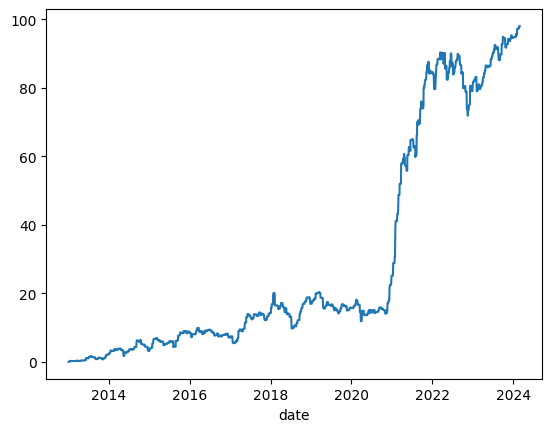

In [13]:
order_matrix = orders(stock_universe_train, delta_window=7)
pnl_matrix = calculate_pnl(order_matrix, stock_universe_train)
universe_pnl = pnl_matrix.sum(axis=1)
universe_pnl.cumsum().plot()
sharpe, max_dd = perf_metrics(universe_pnl)
print(f"Sharpe ratio: {sharpe:.2f}")
print(f"Max drawdown: {max_dd:.2f}%")

## OS backtest

Sharpe ratio: 2.61
Max drawdown: -27.21%


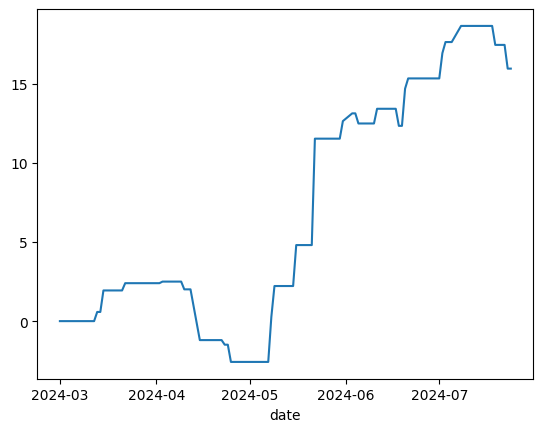

In [14]:
order_matrix = orders(stock_universe_test, delta_window=7)
pnl_matrix = calculate_pnl(order_matrix, stock_universe_test)
universe_pnl = pnl_matrix.sum(axis=1)
universe_pnl.cumsum().plot()
sharpe, max_dd = perf_metrics(universe_pnl) 
print(f"Sharpe ratio: {sharpe:.2f}") 
print(f"Max drawdown: {max_dd:.2f}%")